In [1]:
!pip install py7zr
!pip install tensorflow==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 357 kB 16.0 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 2.3 MB 49.4 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 139 kB 33.4 MB/s 
     |████████████████████████████████| 378 kB 43.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.8 MB 32 kB/s 
     |████████████████████████████████| 14.9 MB 461 kB/s 
     |████████████████████████████████| 132 kB 51.1 MB/s 
     |████████████████████████████████| 2.9 MB 44.0 MB/s 
     |████████████████████████████████| 462 kB 51.6 MB/s 
     |████████████████████████████████| 3.8 MB 38.1 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.

In [2]:
from pandas import DataFrame, read_csv, get_dummies, Series, concat
from pathlib import Path
from numpy import array, random, eye, argmax, set_printoptions, inf
import numpy
import pickle
import py7zr
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers.core import Dropout
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from os.path import split
from random import shuffle
from shutil import rmtree
import random
import glob
from re import findall

In [ ]:
path_to_source_folder = '/content/drive/MyDrive/20_class_csv_facetrimmed.zip'
model_out = Path('/content/drive/MyDrive/20frame_17class_noface_model')
batch_size = 100
ACCURACY_THRESHOLD = 0.95
split_ratio = 0.2       #training validation split

# EXTRACTING ZIP

In [ ]:
path_to_source_folder= '/content/drive/MyDrive/handmask/OutputBird.zip'
!unzip $path_to_source_folder -d /content/ASLdataset

In [ ]:

path_to_source_folder= '/content/drive/MyDrive/handmask/Outputfav.zip'
!unzip $path_to_source_folder -d /content/ASLdataset

In [ ]:
make_dir = Path('/content/ASLdataset')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/ASLdataset')
    path_to_source_folder = Path('/content/ASLdataset/csv')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/ASLdataset
    path_to_source_folder = Path('/content/ASLdataset/csv')
else:
    path_to_source_folder = Path(path_to_source_folder)

Streaming output truncated to the last 5000 lines.
  inflating: /content/ASLdataset/content/new_20class_csv/Name/Name_164.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/20.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/Name_606.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_467168.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/41.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/Name_256.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_387827.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_209857.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_518804.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_103141.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/1.csv  
  inflating: /content/ASLdataset/content/new_20class_csv/Name/name_name_24.csv  
  inflating: /content/ASL

# Initializing variables

In [ ]:
path_to_source_folder = Path('/content/ASLdataset/content/new_20class_csv')
model_name = model_out / 'ADB_9_95'
source_directory = path_to_source_folder
y = []
x = []
f = []
e = []
all_source_ds =[]
x_valid =[]
y_valid = []
f_valid =[]
failed_final_check =[]

# Checking for classes in the *source_directory*

In [ ]:
classes = sorted(list(x.name for x in source_directory.glob('*')))

if any('.ipynb_checkpoints' in s for s in classes):
    classes.remove('.ipynb_checkpoints')
print(classes,"\n",len(classes))

klasses = ['Address', 'Age', 'Class', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your']
classes = klasses
print(classes,"\n",len(classes))

['Address', 'Age', 'Class', 'ExcuseMe', 'Favourite', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'School', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'] 
 20
['Address', 'Age', 'Class', 'How', 'Movie', 'Name', 'Phone', 'Play', 'Please', 'ThankYou', 'Time', 'What', 'When', 'Where', 'Work', 'You', 'Your'] 
 17


# Splitting validation and training data 

In [ ]:
valid_csv_list =[]
train_csv_list =[]
all_source_ds =[]
for category in classes:
    cat_dir = list((source_directory/category).glob("*"))
    all_source_ds.append(cat_dir)
# print(all_source_ds)
all_source_ds_flat = [item for sublist in all_source_ds for item in sublist]
shuffle(all_source_ds_flat)
print(len(all_source_ds_flat))
valid_csv_list = all_source_ds_flat[:int(len(all_source_ds_flat)*split_ratio)]
train_csv_list = all_source_ds_flat[int(len(all_source_ds_flat)*split_ratio):]
# print(all_source_ds_flat)
print(len(all_source_ds_flat))
print("Validation data: ", len(valid_csv_list), "Training data: ", len(train_csv_list))

35604
35604
Validation data:  7120 Training data:  28484


In [ ]:
# d = read_csv(str(valid_csv_list[0]), header=None ).values

# Reading Validation Data

In [ ]:
x_valid =[]
y_valid =[]
label =[]
for csv in valid_csv_list:
    d = read_csv(str(csv), header=None ).values
    if d.shape == (50,225):
            random_number = random.randint(1,20)
            x_valid.append(d[random_number:random_number+30])
            label = split(split(csv)[0])[1]
            print(csv,"  ", label)
            y_valid.append(label)
            
    else:
            f_valid.append(d)
            print(csv,"  ",d.shape)

Streaming output truncated to the last 5000 lines.
/content/ASLdataset/content/new_20class_csv/Please/please_616278.csv    Please
/content/ASLdataset/content/new_20class_csv/Name/name_214095.csv    Name
/content/ASLdataset/content/new_20class_csv/When/201200.csv    When
/content/ASLdataset/content/new_20class_csv/Play/play_873273.csv    Play
/content/ASLdataset/content/new_20class_csv/Name/Name_223.csv    Name
/content/ASLdataset/content/new_20class_csv/Time/341280.csv    Time
/content/ASLdataset/content/new_20class_csv/Name/name_873376.csv    Name
/content/ASLdataset/content/new_20class_csv/How/How_16.csv    How
/content/ASLdataset/content/new_20class_csv/Time/684053.csv    Time
/content/ASLdataset/content/new_20class_csv/Class/141675.csv    Class
/content/ASLdataset/content/new_20class_csv/ThankYou/477866 (2).csv    ThankYou
/content/ASLdataset/content/new_20class_csv/Name/229.csv    Name
/content/ASLdataset/content/new_20class_csv/Your/Your_944409.csv    Your
/content/ASLdataset/con

In [ ]:
# x_valid =[]
# y_valid =[]
# label =[]
# for csv in valid_csv_list:
#     d = read_csv(str(csv), header=None ).values
#     if d.shape == (50,480):
#             # random_number = random.randint(1,20)
#             set_printoptions(threshold=inf)
#             x_valid.append(d)
#             # x_valid = numpy.append(x_valid, d, axis = 0)
#             # x_valid = numpy.append(x_valid,d[random_number:random_number+30])
#             label = split(split(csv)[0])[1]
#             print(csv,"  ", label)
#             y_valid.append(label)
#             # y_valid = numpy.append(y_valid,label, axis = 0)
#     else:
#             f_valid.append(d)
#             print(d.shape)

# Saving Variables

In [ ]:
with open(str(model_out)+'/finalcsvx_valid.pkle','wb') as xyz:
    pickle.dump(x_valid,xyz)
with open(str(model_out)+'/finalcsvy_valid.pkle','wb') as xyz:
    pickle.dump(y_valid,xyz)
with open(str(model_out)+'/finaltrain_csv_list.pkle','wb') as xyz:
    pickle.dump(train_csv_list,xyz)
with open(str(model_out)+'/finalvalid_csv_list.pkle','wb') as xyz:
    pickle.dump(valid_csv_list,xyz)
    

# Loading variables

In [ ]:
with open(str(model_out)+'/finalcsvx_valid.pkle','rb') as xyz:
    x_valid = pickle.load(xyz)
with open(str(model_out)+'/finalcsvy_valid.pkle','rb') as xyz:
    y_valid = pickle.load(xyz)
with open(str(model_out)+'/finaltrain_csv_list.pkle','rb') as xyz:
    train_csv_list = pickle.load(xyz)
with open(str(model_out)+'/finalvalid_csv_list.pkle','rb') as xyz:
    valid_csv_list = pickle.load(xyz)
print(train_csv_list)
shuffle(train_csv_list)
print(train_csv_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(x_valid))

7120


In [ ]:
# print(x_valid[1])
print(y_valid)
# print(train_csv_list)

['Work', 'When', 'Phone', 'Age', 'Play', 'Class', 'Movie', 'Name', 'Please', 'Class', 'You', 'Phone', 'You', 'Please', 'Address', 'Movie', 'Time', 'Class', 'Work', 'What', 'Age', 'Work', 'Where', 'Address', 'Class', 'Time', 'Where', 'Age', 'Your', 'Movie', 'What', 'Please', 'Time', 'You', 'Time', 'Where', 'You', 'How', 'What', 'Age', 'Movie', 'Class', 'ThankYou', 'How', 'Name', 'Address', 'What', 'Name', 'You', 'Time', 'ThankYou', 'ThankYou', 'Where', 'Your', 'You', 'Class', 'You', 'Your', 'Phone', 'Phone', 'Time', 'Age', 'Work', 'Work', 'Play', 'ThankYou', 'What', 'When', 'Where', 'Work', 'Please', 'Work', 'You', 'Name', 'Time', 'ThankYou', 'Your', 'Age', 'What', 'ThankYou', 'Address', 'Phone', 'Where', 'Please', 'ThankYou', 'Where', 'Your', 'You', 'You', 'Movie', 'You', 'Where', 'Age', 'Class', 'Please', 'How', 'Age', 'Time', 'Your', 'How', 'Age', 'Work', 'Please', 'How', 'Where', 'Your', 'Phone', 'Work', 'Where', 'You', 'When', 'What', 'ThankYou', 'ThankYou', 'Movie', 'Time', 'Name'

In [ ]:
print(x_train[1])
print(y_train)

NameError: ignored

# Converting x_valid list to dataframe and y_valid list to one hot vector style

In [ ]:
df = DataFrame({'cat': classes})
dummies = get_dummies(df,prefix='', prefix_sep='')
y_valid = dummies.T.reindex(y_valid).fillna(0).values
x_valid = array(x_valid)
# print(x_valid[1])
print(y_valid)
print(train_csv_list)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# df = DataFrame({'cat': classes})
# dummies = get_dummies(df,prefix='', prefix_sep='')
# y_train = dummies.T.reindex(y_train).fillna(0).values
# x_train = array(x_train)
# # print(x_train[1])
# print(y_train)

# Final check for variables before training

In [ ]:
print('length of y_valid = ' ,y_valid.shape[1])
print('y_valid example = ' ,y_valid[1])
print('shape of x_valid = ', x_valid.shape[1:])
print('length of training data = ', len(train_csv_list))
print('Model will be saved here : ', model_out)

length of y_valid =  17
y_valid example =  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
shape of x_valid =  (30, 225)
length of training data =  28484
Model will be saved here :  /content/drive/MyDrive/20frame_17class_noface_model


In [ ]:
# print('length of y_valid = ' ,y_train.shape[1])
# print('y_valid example = ' ,y_train[1])
# print('shape of x_valid = ', x_train.shape[1:])
# print('length of training data = ', len(valid_csv_list))
# print('Model will be saved here : ', model_out)

In [ ]:
# y_train.dtype

dtype('uint8')

# logs file location set 

In [ ]:
import csv 
csv_name = model_out / "logs.csv"
if not csv_name.exists():
    with open(csv_name, 'w') as csvfile:
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(['count','accuracy','val_accuracy','loss','val_loss'])

# Generator and callback

In [ ]:
def custom_generator(csv_list, batch_size):
    i = 0
    while True:
        batch = {'csv': [], 'labels': []}
        b = 0
        while b < batch_size:
        # for b in range(batch_size):
            # print(len(csv_list))
            if i == (int(len(csv_list))):
                shuffle(csv_list)
                i=0
            # Read data from csv using the name from csv_list
            csv_path = csv_list[i]
            label = split(split(csv_path)[0])[1]

            d = read_csv(str("/" + str(csv_path)), header=None ).values
            if d.shape == (50,225):
                random_number = random.randint(1,20)
                batch['csv'].append(d[random_number:random_number+30])
                batch['labels'].append(label)
                b+=1
            else:
                # print(csv_path,"  ",d.shape)
                failed_final_check.append(csv_path)
            i += 1
        batch['csv'] = array(batch['csv'])
        # Convert labels to categorical values
        df = DataFrame({'cat': classes})
        dummies = get_dummies(df,prefix='', prefix_sep='')
        batch['labels'] = dummies.T.reindex(batch['labels']).fillna(0).values
        # batch['labels'] = eye(len(classes))[batch['labels']]
        # print (batch['labels'],batch['csv'])
        # print("hello")
        # print(type(batch['csv']),type(batch['labels']))
        yield tuple([batch['csv'], batch['labels']])

In [ ]:
start_count = 22
class stop_(Callback): 
    def on_epoch_end(self, epoch, logs={}):
        epoch_count = epoch + start_count
        model.save(Path(str(model_out) + "/model" + str(epoch_count)))
        CSVLogger(str(model_out) + "/model_history_log.csv", append=True)
        with open(csv_name, 'a+') as csvfile:
            csvwriter = csv.writer(csvfile) 
            csvwriter.writerow([epoch_count,logs.get('accuracy'),logs.get('val_accuracy'),logs.get('loss'),logs.get('val_loss')])
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
                print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
                self.model.stop_training = True
stop_training = stop_()     

# Model structure

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(x_valid.shape[1],x_valid.shape[2])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',trainable=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_valid.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            74240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

# Transfer learning

In [ ]:
old_model = load_model('/content/drive/MyDrive/Model/ADB_9_95')

In [ ]:
# hidden = Dense(120, activation='relu')(model.layers[-2].output). model.layers[-1].output

In [ ]:
model_reduced = Sequential()
for layer in old_model.layers[:-1]:
    model_reduced.add(layer)
model_reduced.summary()

In [ ]:
model = Sequential()
model.add(model_reduced)
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.summary()

In [ ]:
x_valid[1].type

AttributeError: ignored

In [ ]:
import scipy
scipy.stats.skew(x_valid[1], axis=0, bias=True)

TypeError: ignored

# Only run when want to resume training from last checkpoint

In [ ]:
model = load_model('/content/drive/MyDrive/20frame_17classmodel/model21')    #load the last checkpoint file

# Training

In [ ]:
len(train_csv_list)//(batch_size)

285

In [ ]:
batch_size = 10
a = Adam(learning_rate=0.00001)
H = model.compile(optimizer=a, loss='categorical_crossentropy', metrics=['accuracy'])
# class_weight = {0: 1.,      #Address
#                 1: 1.,      #Movie
#                 2: 1.,      #Name
#                 3: 1.,      #Phone
#                 4: 1.,      #Play
#                 5: 1.,      #Please
#                 6: 1.,      #Work
#                 7: 1.   }   #Your
history = model.fit_generator(custom_generator(train_csv_list,batch_size), steps_per_epoch=len(train_csv_list)//(batch_size), epochs=1000, verbose=1,  callbacks=[stop_training], validation_data=(x_valid,y_valid))

print('Saving model')
model.save(Path(str(model_out) + "/ADB"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
2848/2848 [==============================] - 596s 208ms/step - loss: 2.7353 - accuracy: 0.1046 - val_loss: 2.1098 - val_accuracy: 0.3028
INFO:tensorflow:Assets written to: /content/drive/MyDrive/20frame_17class_noface_model/model22/assets
Epoch 2/1000
2848/2848 [==============================] - 551s 194ms/step - loss: 2.1569 - accuracy: 0.2995 - val_loss: 1.5516 - val_accuracy: 0.5494
INFO:tensorflow:Assets written to: /content/drive/MyDrive/20frame_17class_noface_model/model23/assets
Epoch 3/1000
2848/2848 [==============================] - 541s 190ms/step - loss: 1.7478 - accuracy: 0.4460 - val_loss: 1.1972 - val_accuracy: 0.6521
INFO:tensorflow:Assets written to: /content/drive/MyDrive/20frame_17class_noface_model/model24/assets
Epoch 4/1000
2848/2848 [==============================] - 543s 191ms/step - loss: 1.4093 - accuracy: 0.5525 - val_loss: 0.8832 - val_accuracy: 0.7427
INFO:tensorflow:Assets written to: /content/drive/MyDrive/20frame_17class_noface_model/model25

In [ ]:
batch_size = len(train_csv_list)
a = Adam(learning_rate=0.00001)
H = model.compile(optimizer=a, loss='categorical_crossentropy', metrics=['accuracy'])
# class_weight = {0: 1.,      #Address
#                 1: 1.,      #Movie
#                 2: 1.,      #Name
#                 3: 1.,      #Phone
#                 4: 1.,      #Play
#                 5: 1.,      #Please
#                 6: 1.,      #Work
#                 7: 1.   }   #Your
# class_weight = {0: 1.,      
#                 1: 1.,      
#                 2: 1.,      
#                 3: 1.     } 
history = model.fit(x_train,y_train, steps_per_epoch=len(train_csv_list)//(batch_size), epochs=1000, verbose=1,  callbacks=[stop_training], validation_data=(x_valid,y_valid))

print('Saving model')
model.save(Path(str(model_out) + "/ADB"))

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import tensorflowjs as tfjs
model = load_model('/content/drive/MyDrive/20frame_17classmodel/model36') 
tfjs.converters.save_keras_model(model, "/content")

ModuleNotFoundError: ignored

Batch size calculator

In [ ]:
curbesst 117
336/336 [==============================] - 2996s 9s/step - loss: 0.2061 - accuracy: 0.9333 - val_loss: 0.1574 - val_accuracy: 0.9499
INFO:tensorflow:Assets written to: /content/drive/MyDrive/20frame_20classmodel/model117/assets

In [ ]:
print(len(train_csv_list)//batch_size)
steps_per_epoch= len(train_csv_list)//(batch_size)
print (steps_per_epoch)

336
336


# Training accuracy, validation accuracy, loss, validation loss plot from *logs.csv*

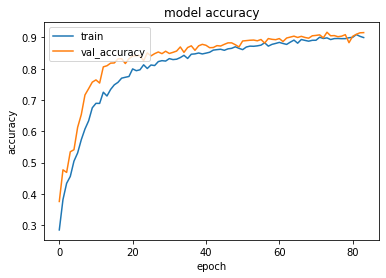

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.read_csv('/content/drive/MyDrive/20frame_4classmodel/logs.csv')
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_accuracy'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

# Testing model

In [ ]:
predictions = model.predict(x_valid)
predictions = argmax(predictions, axis=1)
y_true = argmax(y_valid, axis=1)
cm = confusion_matrix(y_true, predictions,labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Play', 'Work', 'Your', 'Address', 'Name', 'please', 'Phone', 'Movie'])
disp.plot()

In [ ]:
file = open("/content/CM_20frame_20class.pkle",'rb')
object_file = pickle.load(file)
object_file.plot()
file.close()

# old read all files method

In [ ]:
# db = Path('/content/drive/MyDrive/ASL dataset/Generator model files')
# selected_db = db
# all_source_ds = []      #source video location list
# for klass in list(selected_db.glob('*')):
#     print(klass.name)
    
#     for csv in klass.glob('*'):
#         print(csv)
#         d = read_csv(str(csv), header=None ).values
#         if d.shape == (50,1629):
#              e.append(d)
#              y.append(klass.name)
#         else:
#              f.append(d)
#         print(d.shape)

# Validation avi name to csv name

In [ ]:
# import os
# new_train_csv_list =[]
# for item in train_csv_list:      
#     csv_path = item
#     path = os.path.normpath(csv_path)
#     new_train_csv_list.append(Path(os.path.join(*path.split(os.sep)[:2],*path.split(os.sep)[4:])))
# print(new_train_csv_list)
# with open('/content/finaltrain_csv_list.pkle','wb') as xyz:
#     pickle.dump(new_train_csv_list,xyz)

# Save best checkpoint only method callback

In [ ]:
# model_checkpoint_callback  = ModelCheckpoint(filepath = model_out / 'model-{epoch:03d}-{accuracy:03f}.ckpt', verbose=1 , monitor='accuracy', mode='auto', save_best_only=True )

# Random code tests

In [ ]:
import re
from pathlib import Path
source_directory = Path('/content/drive/MyDrive/20frame_8classmodel')

start_count =[]
model_files = list(x.name for x in source_directory.glob('*'))
print(model_files)
for item in model_files:
    s = (re.findall("\d+$",item))
    s = int(s[0]) if s else -1,item
print(max(s))

In [ ]:
def extract_number(f):
    s = re.findall("\d+$",f)
    s = (int(s[0]) if s else -1,f)
    print(s)
    s = re.findall("\d+$",s)
    return int(s[0])

model_files = list(x.name for x in source_directory.glob('*'))
start_count = max(model_files,key=extract_number)
print (start_count)